## Aprendizaje profundo / Deep Learning


#### Integrantes: Franco Amilcar Genolet (francogeno97@gmail.com),Luis Alejandro Guedez Gomez (luis.guedez@dicsys.com)

# Inicialización del entorno

In [1]:

import csv
import functools
import gzip
import pandas as pd
import json
import tempfile
import gzip
import json
import tqdm
import mlflow
import torch.nn.functional as F

from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from tqdm.notebook import tqdm, trange
from gensim.models import KeyedVectors
from torch.utils.data import Dataset, DataLoader, IterableDataset
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import bz2

from sklearn.metrics import classification_report,accuracy_score,f1_score,balanced_accuracy_score

import warnings
warnings.filterwarnings("ignore") 


In [ ]:
# #CORRER UNA VEZ
# !mkdir ./data
# !curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/glove.6B.50d.txt.gz -o ./data/glove.6B.50d.txt.gz
# !curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/meli-challenge-2019.tar.bz2 -o ./data/meli-challenge-2019.tar.bz2
# !tar jxvf ./data/meli-challenge-2019.tar.bz2 -C ./data/
# !pip install mlflow

In [2]:
train_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.train.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)
train_df.head()

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280


In [3]:
train_df_short = train_df[:2000000]

In [4]:
validation_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.validation.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)

In [5]:
test_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.test.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)

In [7]:
data = pd.concat([train_df_short,validation_df,test_df], ignore_index=True)
data

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280
...,...,...,...,...,...,...,...,...,...,...
3287495,spanish,reliable,Gimnasio Gym Manta Bebe Tiny Love Musica Luz M...,BABY_GYMS,test,"[gimnasio, gym, manta, bebe, tiny, love, music...","[1305, 1525, 2620, 915, 1308, 49, 5545, 587, 5...",258,632,63680
3287496,spanish,reliable,Gimnasio Manta Con Actividades Para Bebe 846 Ath,BABY_GYMS,test,"[gimnasio, manta, actividades, bebe, ath]","[1305, 2620, 4625, 915, 6484]",258,632,63680
3287497,spanish,reliable,Gimnasio Bebe Manta Didactica Tiny Love Kick A...,BABY_GYMS,test,"[gimnasio, bebe, manta, didactica, tiny, love,...","[1305, 915, 2620, 9537, 1308, 49, 6872, 1512, ...",258,632,63680
3287498,spanish,reliable,Gimnasio Manta Alfombra Didactica Fitchbaby Ju...,BABY_GYMS,test,"[gimnasio, manta, alfombra, didactica, fitchba...","[1305, 2620, 794, 9537, 1, 282, 9424]",258,632,63680


In [8]:
columns_interesting = ['title','category']
df_filter = data[columns_interesting]
df_filter = df_filter[:1000000]
df_filter

,title,category
0,Casita Muñecas Barbies Pintadas,DOLLHOUSES
1,Neceser Cromado Holográfico,TOILETRY_BAGS
2,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS
3,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS
4,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES
...,...,...
999995,Rasti Kit De 400 Piezas Básicas Libre Armado L...,TOY_BUILDING_SETS
999996,Corralito Bebe Plegable Reforzado Disney Winni...,BABY_PLAYARDS
999997,Proteina Mixta Pulver 1 Kg(huevo + Suero) *glo...,SUPPLEMENTS
999998,Camisa Ufo Jean M/l Talle L Muy Buen Estado,SHIRTS


In [9]:
df_filter['len'] = df_filter['title'].apply(lambda s : len(s))

In [10]:
df_filter

,title,category,len
0,Casita Muñecas Barbies Pintadas,DOLLHOUSES,31
1,Neceser Cromado Holográfico,TOILETRY_BAGS,28
2,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,36
3,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,52
4,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,57
...,...,...,...
999995,Rasti Kit De 400 Piezas Básicas Libre Armado L...,TOY_BUILDING_SETS,54
999996,Corralito Bebe Plegable Reforzado Disney Winni...,BABY_PLAYARDS,52
999997,Proteina Mixta Pulver 1 Kg(huevo + Suero) *glo...,SUPPLEMENTS,60
999998,Camisa Ufo Jean M/l Talle L Muy Buen Estado,SHIRTS,43


<AxesSubplot:ylabel='Frequency'>

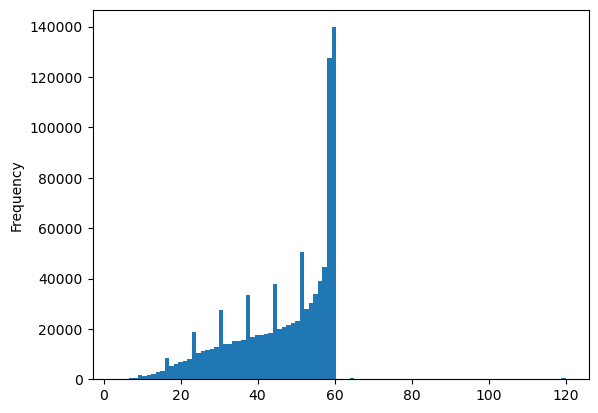

In [11]:
df_filter['len'].plot.hist(bins=100)

In [12]:
count_df = df_filter[['category','title']].groupby('category').aggregate({'title':'count'}).reset_index().sort_values('title',ascending=False)
count_df.head()

,category,title
90,BOOKS,3093
631,WRISTWATCHES,3032
3,ACTION_FIGURES,3032
365,MAGAZINES,3020
411,MUSICAL_KEYBOARDS,2961


In [13]:
target = count_df[count_df['title']>1]['category'].values
target

In [15]:
target.shape

array(['BOOKS', 'WRISTWATCHES', 'ACTION_FIGURES', 'MAGAZINES',
       'MUSICAL_KEYBOARDS', 'DIECAST_VEHICLES', 'JACKETS_AND_COATS',
       'SPARK_PLUGS', 'FOOTBALL_SHIRTS', 'T_SHIRTS', 'RANGES',
       'VIDEO_GAMES', 'BABY_CAR_SEATS', 'PANTS', 'COFFEE_MAKERS',
       'REFRIGERATORS', 'MINI_COMPONENT_SYSTEMS',
       'AUTOMOTIVE_CLUTCH_KITS', 'MOVIES', 'HANDBAGS', 'TELEVISIONS',
       'NOTEBOOKS', 'BACKPACKS', 'FANS', 'TRADING_CARD_GAMES',
       'CEILING_LIGHTS', 'ELECTRIC_GUITARS', 'WOMEN_SWIMWEAR',
       'SOUVENIRS', 'DOLLS', 'AUTOMOTIVE_TIRES', 'CHARMS_AND_MEDALS',
       'COMICS', 'PERFUMES', 'LIGHT_BULBS', 'LIPSTICKS',
       'SEWING_MACHINES', 'PEDAL_EFFECTS', 'SANDALS_AND_FLIP_FLOPS',
       'CARPETS', 'DRINKING_GLASSES', 'SNEAKERS', 'PARTY_PRINTABLE_KITS',
       'CELLPHONE_COVERS', 'ALARMS_AND_SENSORS',
       'SWEATSHIRTS_AND_HOODIES', 'TOY_BUILDING_SETS', 'CAR_WHEELS',
       'SHIRTS', 'SUPPLEMENTS', 'HEADPHONES', 'ELECTRIC_DRILLS',
       'DRAWERS', 'HOME_OFFICE_DESKS', '

In [16]:
import plotly.express as px

In [21]:
count_df['title']

90     3093
631    3032
3      3032
365    3020
411    2961
       ... 
561     147
142     134
318     113
502      79
398      41
Name: title, Length: 632, dtype: int64

In [25]:
px.bar(count_df[count_df['title']>max(count_df['title'])/2],x='category',y='title')

In [26]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [ #We set some filters
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]

        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        

        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        self.dictionary.compactify()

        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1 
        })
        
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}
        

    def _preprocess_string(self, string):
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        #Encodeamos tanto los datos como los targets, diferenciandos los casos cuando son strings y cuando no
        if isinstance(item["data"], str): 
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [27]:
class MyDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

In [28]:
preprocess_train = RawDataProcessor(train_df_short)
train_dataset = MyDataset(train_df_short, transform=preprocess_train)


preprocess_validation = RawDataProcessor(validation_df)
validation_dataset = MyDataset(validation_df, transform=preprocess_validation)


preprocess_test = RawDataProcessor(test_df)
test_dataset = MyDataset(test_df, transform=preprocess_test)

print(f"Datasets loaded with {len(train_dataset)}")

print(f"training elements and {len(train_dataset)} test elements")
print(f"validation elements and {len(validation_dataset)} test elements")
print(f"test elements and {len(test_dataset)} test elements")

print(f"Sample train element:\n{train_dataset[0]}")

Datasets loaded with 2000000
training elements and 2000000 test elements
validation elements and 1223820 test elements
test elements and 63680 test elements
Sample train element:
{'data': [50001, 2, 50000, 3], 'target': 188}


In [29]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

In [30]:
pad_sequences = PadSequences()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,collate_fn=pad_sequences, drop_last=False, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True,collate_fn=pad_sequences, drop_last=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,collate_fn=pad_sequences, drop_last=False, num_workers=0)

In [32]:
class MLPmodelo(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        
        self.hidden1 = nn.Linear(vector_size, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.hidden3 = nn.Linear(256, 256)
        self.output = nn.Linear(256, 632)
        self.vector_size = vector_size
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.output(x)
        
        
        return x

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [35]:
EPOCHS = 2


with mlflow.start_run():
    
    mlflow.log_param("model_name", "MLPmodelo")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden1_size": 256,
        "hidden2_size": 256,
        "hidden3_size": 256
    })
    
    model = MLPmodelo("./data/SBW-vectors-300-min5.txt.bz2",preprocess_train.dictionary, 300, True)
    model.to(device)
    
    loss = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    for epoch in range(EPOCHS):
        
        model.train()
        running_loss = []
        
        for idx, batch in enumerate(tqdm(train_loader)):
            
            inputs = batch["data"].to(device)
            labels = batch["target"].squeeze().long() #aqui si no le pongo .squeeze().long() da el siguiente error:
            #"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss_value = loss(output,labels)
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())           
        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        print(sum(running_loss) / len(running_loss))
        
        
        model.eval()
        running_loss = []
        targets = []
        predictions = []
        
        for idx, batch in enumerate(tqdm(validation_loader)):
                        
            inputs1 = batch["data"].to(device)
            labels1 = batch["target"].squeeze().long()
            labels1 = labels1.to(device)
            
            output = model(inputs1)
            running_loss.append(
                loss(output, labels1).item()
            )

            _, predicted = torch.max(output.data, 1)

            targets.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

            
        mlflow.log_metric("val_loss", sum(running_loss) / len(running_loss), epoch)
        ##todo esto da el siguiente error:Found input variables with inconsistent numbers of samples: [1223936, 1223820]
        #mlflow.log_metric("val_bal_acc", balanced_accuracy_score(targets, predictions), epoch)
        #mlflow.log_metric('f1',f1_score(targets, predictions, average='macro'))
        #mlflow.log_metric('accuracy',accuracy_score(targets, predictions))

  0%|          | 0/15625 [00:00<?, ?it/s]

2.973989295196533


  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/15625 [00:00<?, ?it/s]

1.9941034830856323


  0%|          | 0/9562 [00:00<?, ?it/s]

In [36]:
print(model)

MLPmodelo(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (hidden1): Linear(in_features=300, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=256, bias=True)
  (hidden3): Linear(in_features=256, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=632, bias=True)
)


In [37]:
mlflow.search_runs()
# mlflow.search_runs(experiment_ids='1', filter_string= 'metrics.score_iris > 0.1').head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_loss,metrics.val_loss,params.hidden3_size,params.hidden1_size,params.embedding_size,params.model_name,params.hidden2_size,params.freeze_embedding,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type
0,fc9e67ab7de642a5b371c7a1c9039378,6,FINISHED,file:///users/lguedez/AprendizajeProfundo_Alej...,2022-10-23 19:36:08.391000+00:00,2022-10-23 19:47:59.083000+00:00,1.994103,10.437089,256,256,300,MLPmodelo,256,True,lguedez,/users/lguedez/miniconda3/envs/deeplearning/li...,LOCAL
1,01f949e4adce44038ec9ce09050a0a32,6,FAILED,file:///users/lguedez/AprendizajeProfundo_Alej...,2022-10-23 19:29:35.936000+00:00,2022-10-23 19:32:22.444000+00:00,NaN,NaN,256,256,300,MLPmodelo,256,True,lguedez,/users/lguedez/miniconda3/envs/deeplearning/li...,LOCAL


In [40]:
EPOCHS = 2
FILTERS_COUNT = 100
FILTERS_LENGTH = [2, 3, 4]

In [41]:
class NNClassifier(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        n_labels = 632,
        hidden_layers=[256, 128],
        dropout=0.3
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.convs = []
        for filter_lenght in FILTERS_LENGTH:
            self.convs.append(nn.Conv1d(vector_size, FILTERS_COUNT, filter_lenght))
            self.convs = nn.ModuleList(self.convs)
            self.fc = nn.Linear(FILTERS_COUNT * len(FILTERS_LENGTH), 128)
            self.output = nn.Linear(128, 1)
            self.vector_size = vector_size

        @staticmethod
        def conv_global_max_pool(x, conv):
            return F.relu(conv(x).transpose(1, 2).max(1)[0])

        def forward(self, x):
            x = self.embeddings(x).transpose(1, 2)  # Conv1d takes (batch, channel, seq_len)
            x = [self.conv_global_max_pool(x, conv) for conv in self.convs]
            x = torch.cat(x, dim=1)
            x = F.relu(self.fc(x))
            x = torch.sigmoid(self.output(x))
            return x

In [43]:
mlflow.set_experiment("NNClassifier experiment")

with mlflow.start_run():
    
    model = NNClassifier("./data/SBW-vectors-300-min5.txt.bz2",preprocess_train.dictionary, 300, True)
    
    model = model.to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)

    for epoch in range(EPOCHS):
        
        model.train()
        running_loss = []
        
        for idx, batch in enumerate(tqdm(train_loader)):
            
            inputs = batch["data"].to(device)
            labels = batch["target"].squeeze().long() #aqui si no le pongo .squeeze().long() da el siguiente error:
            #"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss_value = loss(output,labels)
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())           
        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        print(sum(running_loss) / len(running_loss))
        
            
        model.eval()
        running_loss = []
        targets = []
        predictions = []
        
        for idx, batch in enumerate(tqdm(validation_loader)):
                        
            inputs1 = batch["data"].to(device)
            labels1 = batch["target"].squeeze().long()
            labels1 = labels1.to(device)
            
            output = model(inputs1)
            running_loss.append(
                loss(output, labels1).item()
            )

            _, predicted = torch.max(output.data, 1)

            targets.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

            
        mlflow.log_metric("val_loss", sum(running_loss) / len(running_loss), epoch) 

  0%|          | 0/15625 [00:00<?, ?it/s]

NotImplementedError: 